[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

In [1]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Vamos a utilizar el mismo dataset que conocemos de posts anteriores, el dataset `VOC`.

In [2]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar


5717

In [3]:
classes = ["background","aeroplane","bicycle","bird","boat",
"bottle","bus","car","cat","chair","cow","diningtable","dog",
"horse","motorbike","person","pottedplant","sheep","sofa",
"train","tvmonitor"]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

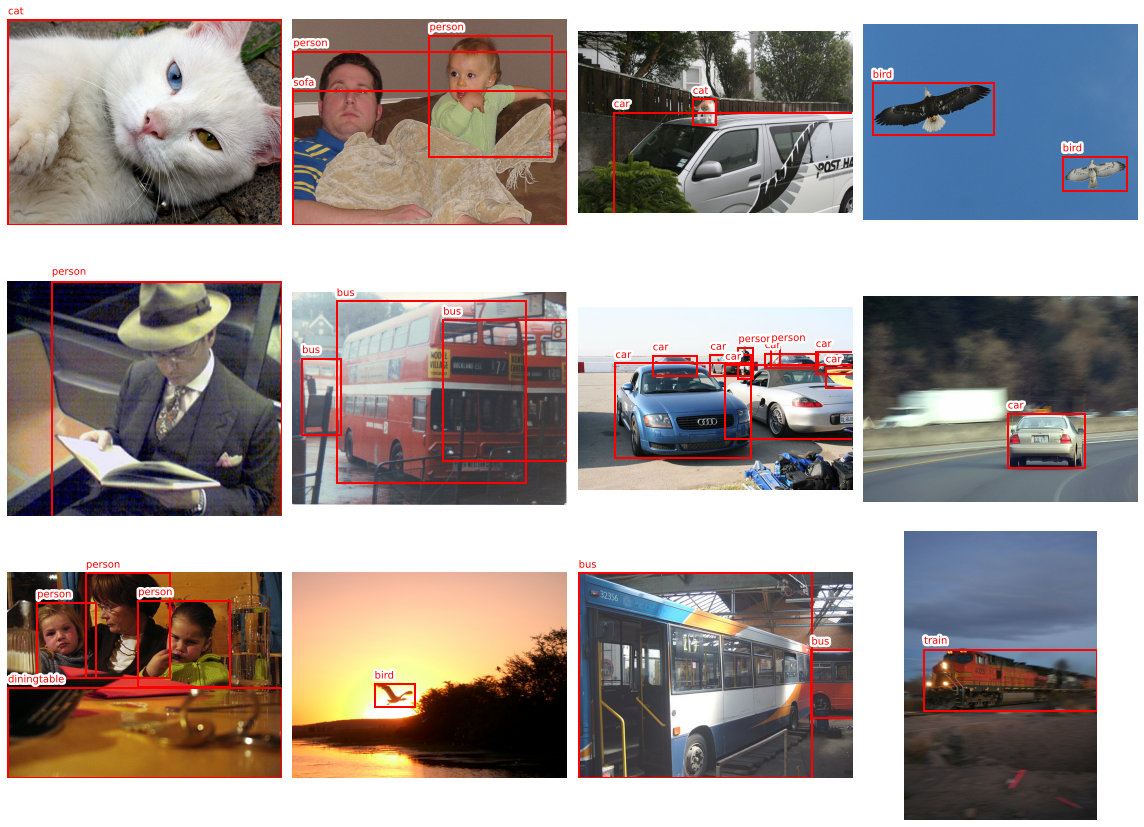

In [5]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [6]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, width, height]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

def xywh2xyxy(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                        cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

In [7]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  # anns is a tuple with (bbs, labels)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    x, y, w, h = bb
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

138

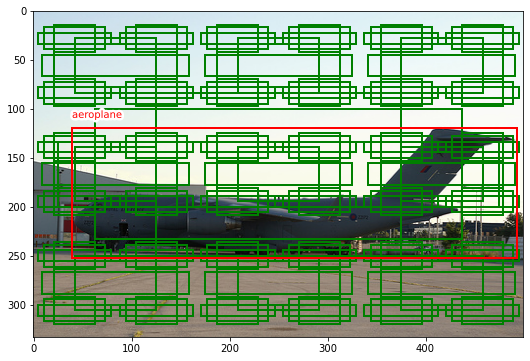

In [50]:
ix = 4445
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [6, 3, 1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
_, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors)

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [52]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
    super().__init__()
    # backbone
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 64)
    self.conv6 = block(64, 64)
    # head
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
    # backbone
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)     # para inputs de 100x100
    x4 = self.conv4(x)    # 6x6
    x5 = self.conv5(x4)   # 3x3
    x6 = self.conv6(x5)   # 1x1

    # head
    o1l, o1c = self.out4(x4)
    o2l, o2c = self.out5(x5)
    o3l, o3c = self.out6(x6)
    return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)    
    #return o3l, o3c

In [53]:
net = SSD(n_classes=len(classes), k=[3, 3, 3])
output = net(torch.rand((64,3,100,100)))
output[0].shape, output[1].shape

(torch.Size([64, 138, 4]), torch.Size([64, 138, 21]))

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 21 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% tanto en la posición del centro de la caja como en sus dimensiones.

In [54]:
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante.

In [55]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [75]:
class SSDLoss(torch.nn.Module):
  def __init__(self, anchors, grid_size):
    super().__init__()
    self.loc_loss = torch.nn.L1Loss()
    self.class_loss = torch.nn.CrossEntropyLoss()
    self.anchors = anchors.to(device)
    self.grid_size = grid_size.to(device)

  def forward(self, outputs, bbs, labels):
    output_bbs, output_labels = outputs
    loc_loss, class_loss = 0, 0
    # cada imagen del batch tiene un número indeterminado de detecciones
    for pred_labels, pred_bbs, _labels, _bbs in zip(output_labels, output_bbs, labels, bbs):
        # aplicar activación
        pred_bbs = actn_to_bb(pred_bbs, self.anchors, self.grid_size)
        # calcular IoU
        _bbs = xywh2xyxy(_bbs)
        overlaps = torchvision.ops.box_iou(_bbs, self.anchors)
        # nos quedamos con las cajas con mejor IoU
        gt_overlap, gt_idx = map_to_ground_truth(overlaps)
        pos = gt_overlap > 0.4
        pos_idx = torch.nonzero(pos)[:,0]
        anchors = pred_bbs[pos_idx]
        # todas las cajas tienen la clase `background` (0) por defecto
        anchor_labels = torch.zeros(len(self.anchors)).long().to(device) 
        tar_idx = gt_idx[pos_idx]
        anchor_labels[pos_idx] = _labels[tar_idx]
        # calculamos loss 
        loc_loss += self.loc_loss(anchors, _bbs[tar_idx])
        class_loss += self.class_loss(pred_labels, anchor_labels)
    return class_loss + loc_loss

## Entrenamiento

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [57]:
def fit(model, X, y1, y2, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        X, y1, y2 = X.to(device), y1.to(device), y2.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y1, y2)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss_loc {np.mean(train_loss_loc):.5f}")

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles.

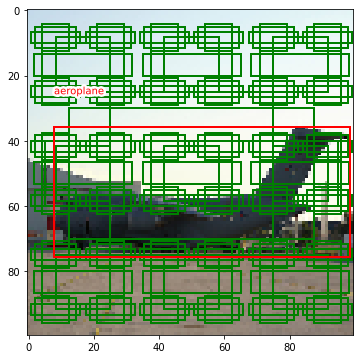

In [58]:
import albumentations as A

# with coco format the bb is expected in 
# [x_min, y_min, width, height] 
def get_aug(aug, min_area=0., min_visibility=0.):
    return A.Compose(aug, bbox_params={'format': 'coco', 'min_area': min_area, 'min_visibility': min_visibility, 'label_fields': ['labels']})

trans = get_aug([A.Resize(100, 100)])

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

#plot_anns(img, (labels, bbs))
plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [59]:
model = SSD(n_classes = len(classes), k=[3, 3, 3])
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0)
bb_norm = norm(bbs[0], img.shape[:2])
bb_tensor = torch.FloatTensor([bb_norm]).unsqueeze(0)
label_tensor = torch.tensor([labels[0]]).long().unsqueeze(0)
fit(model, img_tensor, bb_tensor, label_tensor, epochs=200)

Epoch 1/200 loss_loc 3.11414
Epoch 2/200 loss_loc 3.10037
Epoch 3/200 loss_loc 3.08518
Epoch 4/200 loss_loc 3.06822
Epoch 5/200 loss_loc 3.04874
Epoch 6/200 loss_loc 3.02597
Epoch 7/200 loss_loc 2.99890
Epoch 8/200 loss_loc 2.96656
Epoch 9/200 loss_loc 2.92791
Epoch 10/200 loss_loc 2.88172
Epoch 11/200 loss_loc 2.82688
Epoch 12/200 loss_loc 2.76181
Epoch 13/200 loss_loc 2.68453
Epoch 14/200 loss_loc 2.59371
Epoch 15/200 loss_loc 2.49030
Epoch 16/200 loss_loc 2.36925
Epoch 17/200 loss_loc 2.22771
Epoch 18/200 loss_loc 2.07128
Epoch 19/200 loss_loc 1.89300
Epoch 20/200 loss_loc 1.69805
Epoch 21/200 loss_loc 1.48429
Epoch 22/200 loss_loc 1.26681
Epoch 23/200 loss_loc 1.05069
Epoch 24/200 loss_loc 0.84695
Epoch 25/200 loss_loc 0.67289
Epoch 26/200 loss_loc 0.52924
Epoch 27/200 loss_loc 0.41800
Epoch 28/200 loss_loc 0.34600
Epoch 29/200 loss_loc 0.29352
Epoch 30/200 loss_loc 0.25018
Epoch 31/200 loss_loc 0.21103
Epoch 32/200 loss_loc 0.18280
Epoch 33/200 loss_loc 0.17663
Epoch 34/200 loss_l

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [60]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.argmax(labels, axis=2)[0]

In [61]:
bbs, labels = predict(model, img_tensor)
bbs = xyxy2xywh(bbs)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

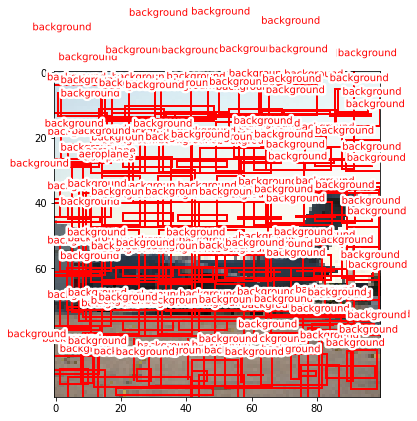

In [62]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

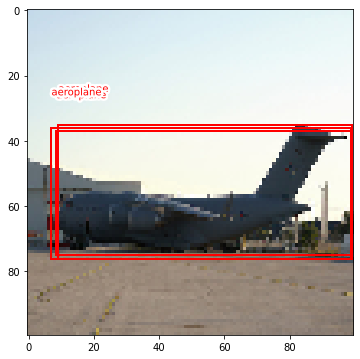

In [63]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [72]:
bbs, labels = predict(model, img_tensor)
bbs = xyxy2xywh(bbs)
# quitar bg
bbs, labels = bbs[labels > 0], labels[labels > 0]
bbs, labels

(tensor([[0.0915, 0.3504, 0.9009, 0.4108],
         [0.0847, 0.3696, 0.9075, 0.3811],
         [0.0702, 0.3608, 0.9191, 0.4024]]),
 tensor([1, 1, 1], device='cuda:0'))

In [73]:
nms_ixs = torchvision.ops.nms(bbs, labels.cpu().float(), iou_threshold=0.1)
nms_ixs

tensor([0])

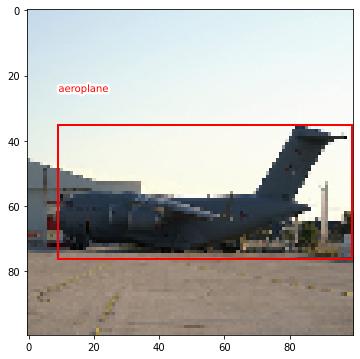

In [74]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.